In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning and processing

In [2]:
#importing the data
df=pd.read_csv('C:\\Users\\Ramya\\Desktop\\All abt BA\\finance\\lcData4m.csv',na_values=['NaN','nan',' '])

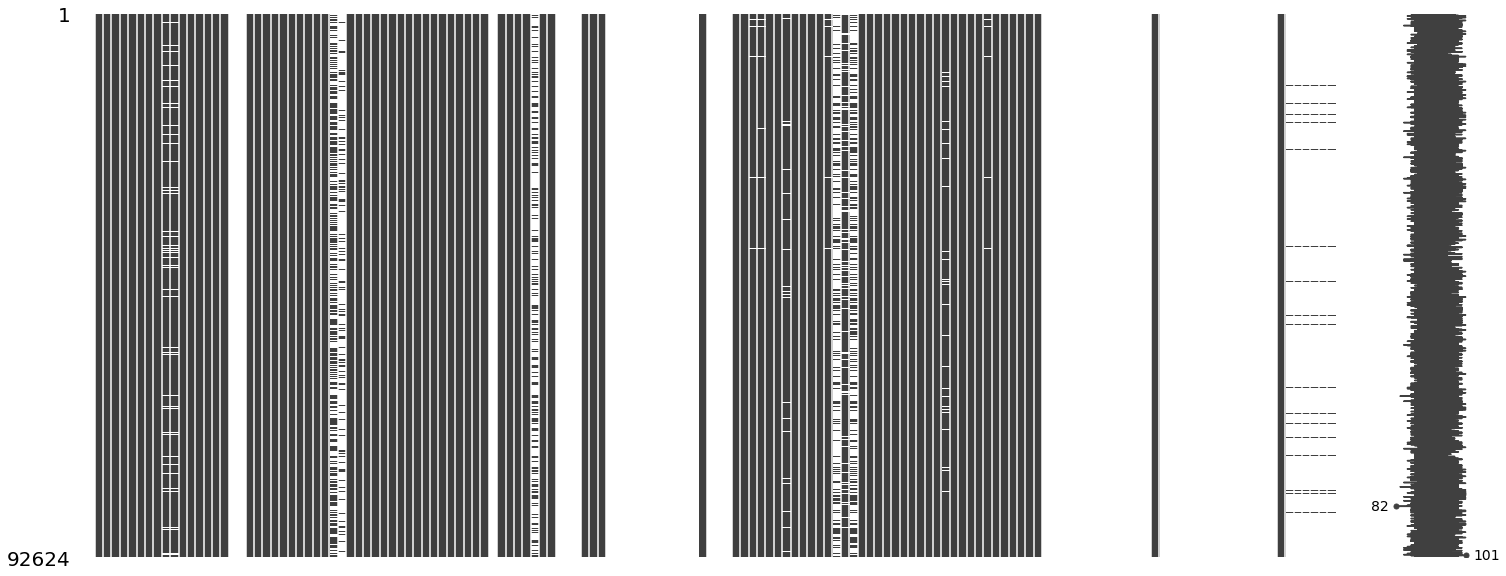

In [3]:
#check for missing values
import missingno as msno  
msno.matrix(df) 

In [4]:
#exclude all columns with missing values greater than 70% of total
df0=df.dropna(thresh=df.shape[0]*0.70,how='all',axis=1)


In [5]:
#check for missing values if any
df0[df0.columns[df0.isnull().any()]].isnull().sum()*100/df0.shape[0]


emp_title                 6.598722
emp_length                6.600881
revol_util                0.053982
last_pymnt_d              0.080973
bc_open_to_buy            0.967352
bc_util                   1.041847
mo_sin_old_il_acct        3.543358
mths_since_recent_bc      0.944680
mths_since_recent_inq    11.161254
num_tl_120dpd_2m          5.869969
percent_bc_gt_75          1.070997
dtype: float64

In [6]:
#convert certain categorical columns into numerical
df0['revol_util']=df0.revol_util.str.extract('(\d+)')
df0['revol_util']=pd.to_numeric(df0['revol_util'], downcast ='signed')

In [7]:
df0['int_rate']=df['int_rate'].replace('%','',regex=True).astype(float)


In [8]:
#replace Nan values with majority_voting in all categorical variables
for c in list(df0.select_dtypes(include=['O']).columns):
    df0[c].fillna(df0[c].value_counts().index[0],inplace=True)   

In [9]:
#replace Nan values with mean for all numerical variables
for c in list(df0.select_dtypes(exclude=['O']).columns):
    df0[c].fillna(df0[c].mean(),inplace=True)

In [10]:
category = list(df0.select_dtypes(include=['O']).columns)
sorted(category)

['addr_state',
 'application_type',
 'debt_settlement_flag',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'grade',
 'hardship_flag',
 'home_ownership',
 'initial_list_status',
 'issue_d',
 'last_credit_pull_d',
 'last_pymnt_d',
 'loan_status',
 'purpose',
 'pymnt_plan',
 'sub_grade',
 'term',
 'title',
 'verification_status',
 'zip_code']

In [11]:
#check for relation with target variable for all categorical attributes
from scipy.stats import chi2_contingency
def chi_test():
    for y in df0[category]:
        p=chi2_contingency(pd.crosstab(df['loan_status'],df[y]))[1]
        print('p-value is '+y+" "+str(p))

In [12]:
chi_test()

p-value is term 1.0
p-value is grade 0.0
p-value is sub_grade 0.0
p-value is emp_title 8.689441837551794e-05
p-value is emp_length 0.000570815911905607
p-value is home_ownership 1.9812246042308414e-111
p-value is verification_status 9.302982009253966e-162
p-value is issue_d 0.00994227539398323
p-value is loan_status 0.0
p-value is pymnt_plan 1.0
p-value is purpose 1.4677554658578412e-58
p-value is title 1.3635879891134396e-59
p-value is zip_code 9.115434887758029e-21
p-value is addr_state 6.63425935823253e-33
p-value is earliest_cr_line 3.7503852958649143e-17
p-value is initial_list_status 3.5358651533896824e-59
p-value is last_pymnt_d 0.0
p-value is last_credit_pull_d 0.0
p-value is application_type 1.0
p-value is hardship_flag 1.0
p-value is debt_settlement_flag 0.0


In [13]:
#drop columns that show no relation or univariate columns
df0.drop(['application_type','hardship_flag','pymnt_plan','term','sub_grade','zip_code'],axis=1,inplace=True)

In [14]:
df0.drop(['addr_state','earliest_cr_line','emp_title',"last_pymnt_d",'last_credit_pull_d'],axis=1,inplace=True)

In [15]:
#for convenience replacing fully paid as 1 and chargeoff as 0
df0['loan_status']=np.where(df0['loan_status']=='Fully Paid','1','0')

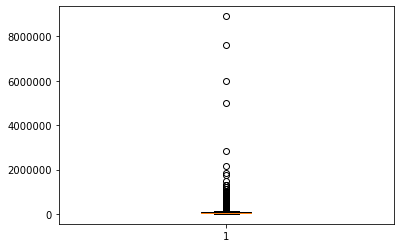

In [16]:
#There are 301 outliers which is way less than rows
v=plt.boxplot(df0['annual_inc'])

In [17]:
df0["annual_inc"][df0["annual_inc"] >1000000].shape

(16,)

In [18]:
df0["annual_inc"] = np.where(df0["annual_inc"] >1000000, df0["annual_inc"].quantile(0.25),df['annual_inc'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1ed1e713f48>,
 'caps': [<matplotlib.lines.Line2D at 0x1ed0b7e6f08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ed0b9bc188>],
 'medians': [<matplotlib.lines.Line2D at 0x1ed0b7e7f48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ed0b7e7988>],
 'means': []}

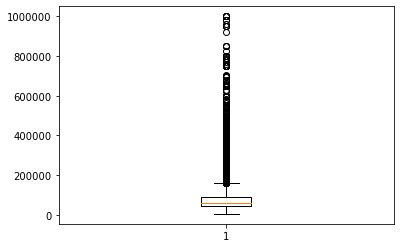

In [19]:
plt.boxplot(df0['annual_inc'])

In [20]:
dt_series = pd.to_datetime(df0['issue_d'])
df0['year'] = dt_series.dt.year

In [21]:
#re-check on missing values
df0[df0.columns[df0.isnull().any()]].isnull().sum()*100/df0.shape[0]

Series([], dtype: float64)

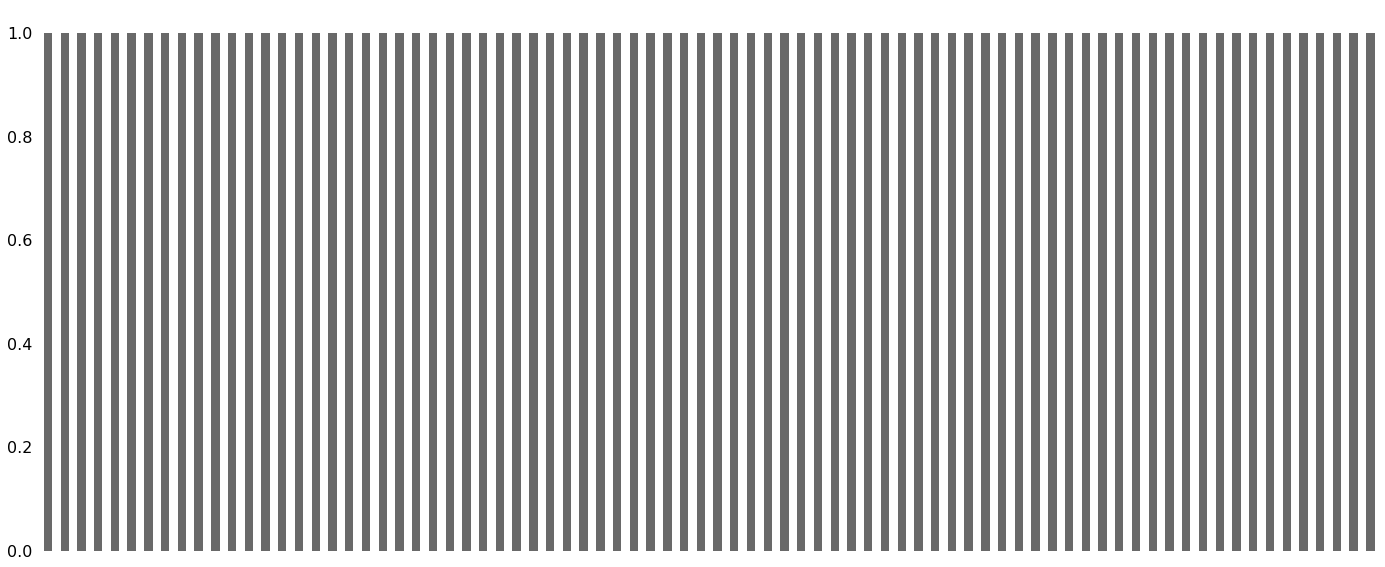

In [22]:
#visual check
msno.bar(df0)

# Feature extraction using Decision tree

In [23]:
#only categorical data in order to minimise number of dummies
cat = list(df0.select_dtypes(include=['O']).columns)
cat

['grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'title',
 'initial_list_status',
 'debt_settlement_flag']

In [24]:
#list of numerical data
num = list(df0.select_dtypes(exclude=['O']).columns)
sorted(num)


['acc_now_delinq',
 'acc_open_past_24mths',
 'annual_inc',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'funded_amnt_inv',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'last_fico_range_high',
 'last_fico_range_low',
 'last_pymnt_amnt',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'out_prncp',
 'out_prncp_inv',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'policy_code',
 'pub_rec',
 'pub_rec_bankruptcies',

In [25]:
data_num=df0[num].join(df0['loan_status'])

In [26]:
X=data_num.drop(["loan_status"],axis=1)
y=data_num['loan_status']

In [27]:
X.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       '

In [28]:
import sklearn.model_selection as model_selection
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.3,random_state=200)

In [29]:
from sklearn.ensemble import RandomForestClassifier
reg=RandomForestClassifier(n_estimators=50,max_depth=3,oob_score=True,random_state=1)


In [30]:
X_train[X_train.columns[X_train.isnull().any()]].isnull().sum()*100/X_train.shape[0]

Series([], dtype: float64)

In [31]:
reg.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=50, oob_score=True,
                       random_state=1)

In [32]:
reg.score(X_test,y_test)

0.963833309342162

In [33]:
reg.oob_score_

0.9650194336479734

In [34]:
len(reg.estimators_)

50

In [35]:
import numpy as np
par=[]
for i in reg.estimators_:
    par.append(i.feature_importances_)

In [36]:
par=np.mean(par,axis=0)
feature_importance=pd.Series(par,index=X_train.columns.tolist()).sort_values(ascending=False)
feature_importance

collection_recovery_fee       0.308902
recoveries                    0.259276
last_fico_range_low           0.111737
last_fico_range_high          0.074291
total_rec_prncp               0.068819
                                ...   
num_il_tl                     0.000000
num_bc_tl                     0.000000
collections_12_mths_ex_med    0.000000
policy_code                   0.000000
year                          0.000000
Length: 70, dtype: float64

In [37]:
d=feature_importance[feature_importance>0.002]

In [38]:
d=list(np.array(d.index))
d

['collection_recovery_fee',
 'recoveries',
 'last_fico_range_low',
 'last_fico_range_high',
 'total_rec_prncp',
 'total_pymnt_inv',
 'last_pymnt_amnt',
 'total_pymnt',
 'funded_amnt_inv',
 'funded_amnt',
 'int_rate',
 'installment',
 'total_rec_late_fee',
 'loan_amnt']

In [39]:
x=sorted(zip(map(lambda x: round(x, 4), reg.feature_importances_), X.columns),reverse=True)
x[1:17]

[(0.2593, 'recoveries'),
 (0.1117, 'last_fico_range_low'),
 (0.0743, 'last_fico_range_high'),
 (0.0688, 'total_rec_prncp'),
 (0.0459, 'total_pymnt_inv'),
 (0.0258, 'last_pymnt_amnt'),
 (0.0247, 'total_pymnt'),
 (0.0216, 'funded_amnt_inv'),
 (0.0208, 'funded_amnt'),
 (0.0077, 'int_rate'),
 (0.007, 'installment'),
 (0.0066, 'total_rec_late_fee'),
 (0.0031, 'loan_amnt'),
 (0.0019, 'fico_range_high'),
 (0.0017, 'total_rec_int'),
 (0.0012, 'tot_hi_cred_lim')]

In [40]:
import sklearn.tree as tree
clf=tree.DecisionTreeClassifier(max_depth=3,random_state=200)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, random_state=200)

In [41]:
clf.score(X_test,y_test)

0.9655606736720886

In [42]:
pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False).head(7)

recoveries              0.903243
last_fico_range_high    0.044496
last_pymnt_amnt         0.033564
total_rec_prncp         0.018698
total_pymnt_inv         0.000000
total_rec_int           0.000000
total_rec_late_fee      0.000000
dtype: float64

In [43]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
clf=BaggingClassifier(oob_score=True,n_jobs=-1,n_estimators=20,random_state=400,
                      base_estimator=DecisionTreeClassifier())

In [44]:
clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20,
                  n_jobs=-1, oob_score=True, random_state=400)

In [45]:
clf.score(X_test,y_test)

0.9948179070102202

In [46]:
len(clf.estimators_)

20

In [47]:
import numpy as np
par=[]
for i in reg.estimators_:
    par.append(i.feature_importances_)

In [48]:
par=np.mean(par,axis=0)
feature_importance=pd.Series(par,index=X_train.columns.tolist()).sort_values(ascending=False)

In [49]:
e=feature_importance[feature_importance>0.004]
e=list(np.array(e.index))
e

['collection_recovery_fee',
 'recoveries',
 'last_fico_range_low',
 'last_fico_range_high',
 'total_rec_prncp',
 'total_pymnt_inv',
 'last_pymnt_amnt',
 'total_pymnt',
 'funded_amnt_inv',
 'funded_amnt',
 'int_rate',
 'installment',
 'total_rec_late_fee']

# Model Building with all relevent attributes wrt loanStatus

In [50]:
lc=df0[e].join(df0[cat])

In [51]:
lc.shape

(92624, 23)

In [52]:
lc.columns

Index(['collection_recovery_fee', 'recoveries', 'last_fico_range_low',
       'last_fico_range_high', 'total_rec_prncp', 'total_pymnt_inv',
       'last_pymnt_amnt', 'total_pymnt', 'funded_amnt_inv', 'funded_amnt',
       'int_rate', 'installment', 'total_rec_late_fee', 'grade', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'initial_list_status', 'debt_settlement_flag'],
      dtype='object')

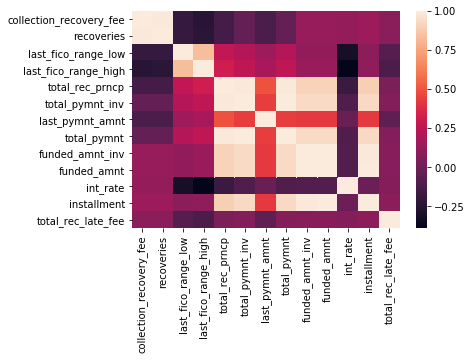

In [54]:
import seaborn as sns
sns.heatmap(lc.corr())

In [55]:
X=lc.drop(["loan_status"],axis=1)
y=lc['loan_status']

In [56]:
X=pd.get_dummies(X,prefix_sep='_')


In [57]:
X.shape

(92624, 70)

In [58]:
import sklearn.model_selection as model_selection
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.2,random_state=200)

In [ ]:
##################            DECISION TREE MODEL        ####################

In [59]:
import sklearn.tree as tree
clf=tree.DecisionTreeClassifier(max_depth=3,random_state=200)


In [60]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, random_state=200)

In [61]:
prob=clf.predict_proba(X_test)
prob

array([[0.012707, 0.987293],
       [0.012707, 0.987293],
       [0.012707, 0.987293],
       ...,
       [1.      , 0.      ],
       [0.012707, 0.987293],
       [0.012707, 0.987293]])

In [62]:
import sklearn.metrics as metrics
metrics.roc_auc_score(y_test,prob[:,1])

0.9599029281120595

In [63]:
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         class_names=["0","1"],  
                         filled=True, rounded=True,  
                       proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data) 

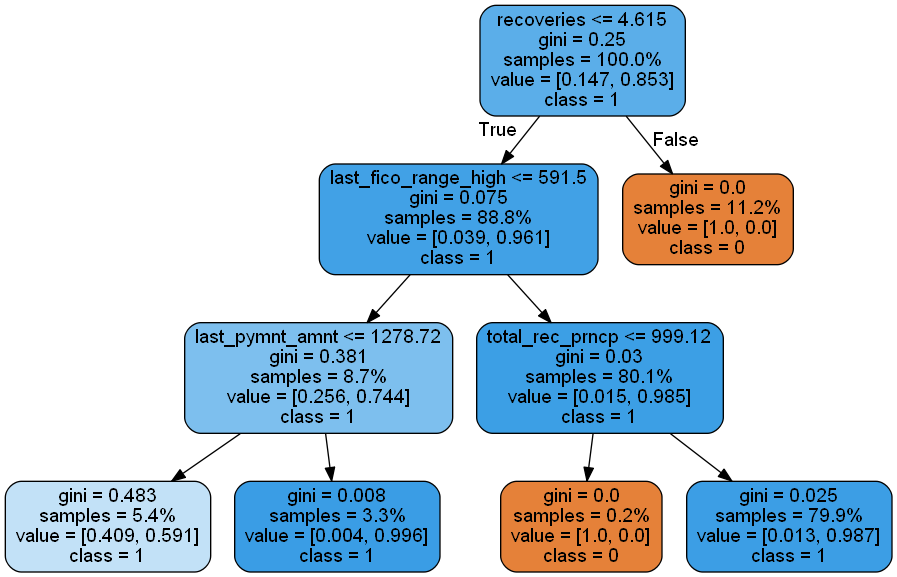

In [64]:
from IPython.display import Image
Image(graph.create_png())

In [65]:
#import sklearn.metrics as metrics
metrics.roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

0.9599029281120595

In [66]:
#Feature importance
pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

recoveries                      0.901553
last_fico_range_high            0.044497
last_pymnt_amnt                 0.032843
total_rec_prncp                 0.021106
debt_settlement_flag_Y          0.000000
                                  ...   
issue_d_2015-09-01T00:00:00Z    0.000000
issue_d_2015-08-01T00:00:00Z    0.000000
issue_d_2015-07-01T00:00:00Z    0.000000
issue_d_2015-06-01T00:00:00Z    0.000000
collection_recovery_fee         0.000000
Length: 70, dtype: float64

In [67]:
#######################         BAGGING ENSEMBLE METHOD       ####################


In [68]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [69]:
clf=BaggingClassifier(oob_score=True,n_jobs=-1,n_estimators=20,random_state=400,
                      base_estimator=DecisionTreeClassifier())#1=OOBSCORE,using the cores of the system,NO.OF TRESS,,BASELEARNER

In [70]:
clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20,
                  n_jobs=-1, oob_score=True, random_state=400)

In [71]:
clf.score(X_test,y_test)

0.9961133603238866

In [72]:
clf.oob_score_

0.9966666216818041

In [73]:
#######################          RANDOM FOREST     #################

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
clf=RandomForestClassifier(n_estimators=80,oob_score=True,n_jobs=-1,random_state=400)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=80, n_jobs=-1, oob_score=True,
                       random_state=400)

In [76]:
clf.oob_score_

0.994763761994089

In [77]:
clf.score(X_test,y_test)

0.9938461538461538

In [78]:
from sklearn import metrics
metrics.roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

0.999598876873512

In [79]:
pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False).head(20)

collection_recovery_fee             0.245443
recoveries                          0.187470
total_rec_prncp                     0.098365
last_fico_range_high                0.091380
last_fico_range_low                 0.068148
last_pymnt_amnt                     0.045045
installment                         0.043170
total_pymnt                         0.042729
funded_amnt                         0.039448
funded_amnt_inv                     0.034262
total_pymnt_inv                     0.031651
debt_settlement_flag_N              0.023899
debt_settlement_flag_Y              0.018389
total_rec_late_fee                  0.005022
int_rate                            0.004717
grade_A                             0.001594
grade_D                             0.001099
verification_status_Not Verified    0.000940
grade_C                             0.000797
title_Debt consolidation            0.000795
dtype: float64

In [80]:
#######################          ADA-BOOSTING      ####################

In [81]:
from sklearn.ensemble import AdaBoostClassifier
clf=AdaBoostClassifier(n_estimators=50,random_state=400)
clf.fit(X_train,y_train)

AdaBoostClassifier(random_state=400)

In [82]:
clf.score(X_test,y_test)

0.9930904183535763

In [83]:
#####################         GRADIENT BOOSTING         ##############

In [84]:
from sklearn.ensemble import GradientBoostingClassifier
clf=GradientBoostingClassifier(n_estimators=80,random_state=400)
clf.fit(X_train,y_train)

GradientBoostingClassifier(n_estimators=80, random_state=400)

In [85]:

clf.score(X_test,y_test)

0.9926045883940621